# TRAIN MODEL

# Cài thư viện hổ trợ chuyển đổi mô hình sang format ONNX

In [1]:
#%pip install scikit-learn==0.22.2.post1
# %pip install onnx==1.11.0

## Import necessary libraries

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

## Read dataset

In [2]:
import pandas as pd
df = pd.read_csv("data.csv")

Mô hình ONNX không hỗ trợ kiểu double (float64) nên ta sẽ tiến hành ép kiểu về float32

In [3]:
df['STDNT_TEST_ENTRANCE_COMB'] = df['STDNT_TEST_ENTRANCE_COMB'].astype('float32')
df['DISTANCE_FROM_HOME'] = df['DISTANCE_FROM_HOME'].astype('float32')
df['DIFF_SECOND_TERM'] = df['DIFF_SECOND_TERM'].astype('float32')

## Split training and testing data sets
- 70% of the data is used to train the model.
- 30% of the data is used to test the model.

In [4]:
from sklearn.model_selection import train_test_split

train_df, test_df = train_test_split(df, test_size=0.3, random_state=123)

x_train = pd.DataFrame(train_df.drop(['RETURNED_2ND_YR'], axis = 1))
y_train = pd.DataFrame(train_df.iloc[:,train_df.columns.tolist().index('RETURNED_2ND_YR')])

x_test = pd.DataFrame(test_df.drop(['RETURNED_2ND_YR'], axis = 1))
y_test = pd.DataFrame(test_df.iloc[:,test_df.columns.tolist().index('RETURNED_2ND_YR')])

## Export test data as CSV
Export the test data as a CSV file. Later, we will load the CSV file into Synapse SQL pool to test the model (score model)

In [5]:
import pandas as pd
from adlfs import AzureBlobFileSystem

account_key = ''
account_name = ''

adls_path = 'abfss://data@nhatlongstorage.dfs.core.windows.net/test_data.csv'

# Create AzureBlobFileSystem instance with account key
fs = AzureBlobFileSystem(account_name=account_name, account_key=account_key)

# Write DataFrame to CSV on Azure Data Lake Storage
with fs.open(adls_path, 'w') as f:
    test_df.to_csv(f, index=False)

print("DataFrame saved to Azure Data Lake Storage.")

DataFrame saved to Azure Data Lake Storage.


In [6]:
import pandas as pd

data_types = df.drop(labels='RETURNED_2ND_YR',axis=1).dtypes
data_types_df = pd.DataFrame(data_types, columns=['Data Type'])
data_types_df['Column'] = data_types_df.index
data_types_count = data_types_df['Data Type'].value_counts().reset_index()
data_types_count.columns = ['Data Type', 'Column Count']
print(data_types_count)
print("\nDanh sách các cột cho mỗi kiểu dữ liệu:")
for dtype in data_types_count['Data Type']:
    columns_of_type = data_types_df[data_types_df['Data Type'] == dtype]['Column'].tolist()
    print(f"\nKiểu dữ liệu {dtype}:")
    print(columns_of_type)

  Data Type  Column Count
0    object            18
1     int64             9
2   float32             3

Danh sách các cột cho mỗi kiểu dữ liệu:

Kiểu dữ liệu object:
['STDNT_BACKGROUND', 'STDNT_MAJOR', 'CORE_COURSE_NAME_1_F', 'CORE_COURSE_GRADE_1_F', 'CORE_COURSE_NAME_2_F', 'CORE_COURSE_GRADE_2_F', 'CORE_COURSE_NAME_3_F', 'CORE_COURSE_GRADE_3_F', 'CORE_COURSE_NAME_1_S', 'CORE_COURSE_GRADE_1_S', 'CORE_COURSE_NAME_2_S', 'CORE_COURSE_GRADE_2_S', 'CORE_COURSE_NAME_3_S', 'CORE_COURSE_GRADE_3_S', 'FATHER_HI_EDU_DESC', 'MOTHER_HI_EDU_DESC', 'DEGREE_GROUP_DESC', 'HIGH_SCHL_GPA_CLASSIFY']

Kiểu dữ liệu int64:
['STDNT_AGE', 'STDNT_GENDER', 'IN_STATE_FLAG', 'INTERNATIONAL_STS', 'FIRST_TERM', 'HOUSING_STS', 'GROSS_FIN_NEED', 'EST_FAM_CONTRIBUTION', 'DIFF_FIRST_TERM']

Kiểu dữ liệu float32:
['STDNT_TEST_ENTRANCE_COMB', 'DISTANCE_FROM_HOME', 'DIFF_SECOND_TERM']


In [7]:
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder

float_features = ['STDNT_TEST_ENTRANCE_COMB', 'DISTANCE_FROM_HOME', 'DIFF_SECOND_TERM']
float_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())])

integer_features = ['STDNT_AGE', 'STDNT_GENDER', 'IN_STATE_FLAG', 'INTERNATIONAL_STS', 'FIRST_TERM', 'HOUSING_STS', 'GROSS_FIN_NEED', 'EST_FAM_CONTRIBUTION', 'DIFF_FIRST_TERM']
integer_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())])

categorical_features = ['STDNT_BACKGROUND', 'STDNT_MAJOR', 'CORE_COURSE_NAME_1_F', 'CORE_COURSE_GRADE_1_F', 'CORE_COURSE_NAME_2_F', 'CORE_COURSE_GRADE_2_F', 'CORE_COURSE_NAME_3_F', 'CORE_COURSE_GRADE_3_F', 'CORE_COURSE_NAME_1_S', 'CORE_COURSE_GRADE_1_S', 'CORE_COURSE_NAME_2_S', 'CORE_COURSE_GRADE_2_S', 'CORE_COURSE_NAME_3_S', 'CORE_COURSE_GRADE_3_S', 'FATHER_HI_EDU_DESC', 'MOTHER_HI_EDU_DESC', 'DEGREE_GROUP_DESC', 'HIGH_SCHL_GPA_CLASSIFY']
categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

preprocessor = ColumnTransformer(
    transformers=[
        ('float', float_transformer, float_features),
        ('integer', integer_transformer, integer_features),
        ('cat', categorical_transformer, categorical_features)
    ])

clf = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', LogisticRegression(solver='lbfgs'))])

# Train the model
clf.fit(x_train, y_train)

/anaconda/envs/azureml_py38/lib/python3.8/site-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/anaconda/envs/azureml_py38/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:938: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Pipeline(memory=None,
         steps=[('preprocessor',
                 ColumnTransformer(n_jobs=None, remainder='drop',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('float',
                                                  Pipeline(memory=None,
                                                           steps=[('imputer',
                                                                   SimpleImputer(add_indicator=False,
                                                                                 copy=True,
                                                                                 fill_value=None,
                                                                                 missing_values=nan,
                                                                                 strategy='median',
                                                           

In [8]:
# Evalute the model
score = clf.score(x_test, y_test)
print(score)

0.8323529411764706


In [9]:
from sklearn.metrics import classification_report

y_pred = clf.predict(x_test)

classes = target_names = ['class 0', 'class 1']
print(classification_report(y_test, y_pred, target_names=classes))

              precision    recall  f1-score   support

     class 0       0.70      0.33      0.45       210
     class 1       0.85      0.96      0.90       810

    accuracy                           0.83      1020
   macro avg       0.77      0.65      0.67      1020
weighted avg       0.82      0.83      0.81      1020



Text(0.5, 1.0, 'Logistic Regression Accuracy Score: 0.8323529411764706')

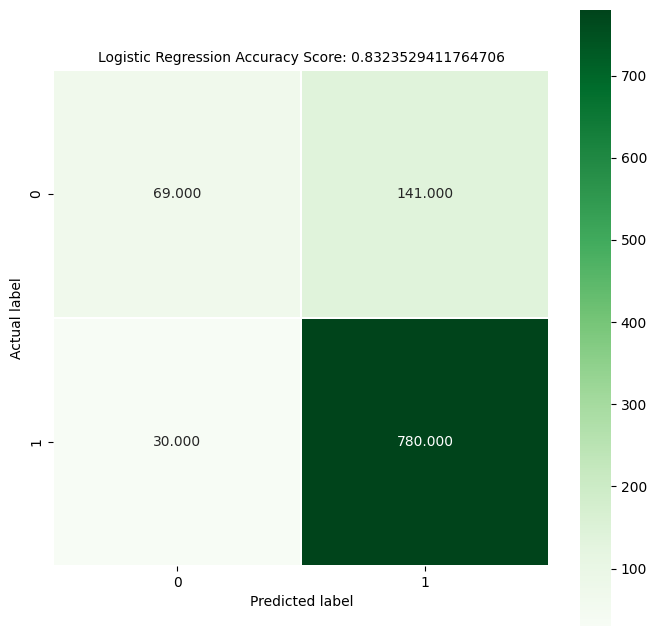

In [10]:
from sklearn import metrics
lg_cm = metrics.confusion_matrix(y_test,y_pred)
lg_score = metrics.accuracy_score(y_test, y_pred)

plt.figure(figsize=(8,8))
sns.heatmap(lg_cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap='Greens');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
title = 'Logistic Regression Accuracy Score: {0}'.format(lg_score)
plt.title(title, size = 10)

## Convert the model to ONNX format
Currently, T-SQL scoring only supports ONNX model format (https://onnx.ai/).

In [11]:
from skl2onnx import convert_sklearn
from skl2onnx.common.data_types import FloatTensorType, Int64TensorType, DoubleTensorType, StringTensorType

def convert_dataframe_schema(df, drop=None):
    inputs = []
    for k, v in zip(df.columns, df.dtypes):
        if drop is not None and k in drop:
            continue
        if v == 'int64':
            t = Int64TensorType([1, 1])
        elif v == 'float32':
            t = FloatTensorType([1, 1])
        elif v == 'float64':
            t = DoubleTensorType([1, 1])
        else:
            t = StringTensorType([1, 1])
        inputs.append((k, t))
    return inputs

model_inputs = convert_dataframe_schema(x_train)
onnx_model = convert_sklearn(clf, "log_onnx", model_inputs)

The maximum opset needed by this model is only 11.
The maximum opset needed by this model is only 1.


# Register the model format ONNX with MLFlow

In [12]:
from azureml.core import Workspace

ws = Workspace.from_config()
print(ws.name, ws.resource_group, ws.location, ws.subscription_id, sep='\n')

azureml
cloudcomputingproject
eastus2
f8f08080-5dd9-4457-8e82-7fba247e8dfe


In [13]:
import mlflow
import mlflow.onnx

from mlflow.models.signature import infer_signature

experiment_name = 'log_onnx_exp'
artifact_path = 'log_onnx_artifact'

mlflow.set_tracking_uri(ws.get_mlflow_tracking_uri())
mlflow.set_experiment(experiment_name)

with mlflow.start_run() as run:
    # Infer signature
    input_sample = x_train.head(1)
    output_sample = pd.DataFrame(columns=['output_label'], data=[1])
    signature = infer_signature(input_sample, output_sample)

    # Save the model to the outputs directory for capture
    mlflow.onnx.log_model(onnx_model, artifact_path, signature=signature, input_example=input_sample)

    # Register the model to AML model registry
    mlflow.register_model('runs:/' + run.info.run_id + '/' + artifact_path, 'log_onnx')

2023/12/10 03:18:41 INFO mlflow.tracking.fluent: Experiment with name 'log_onnx1_exp' does not exist. Creating a new experiment.
/anaconda/envs/azureml_py38/lib/python3.8/site-packages/mlflow/models/signature.py:137: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input)
/anaconda/envs/azureml_py38/lib/python3.8/site-packages/mlflow/models/signatu